# 1. Data loading and preprocessing

In [1]:
import os
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import joblib

In [2]:
# Read the Parquet file into a DataFrame
# list of files in '../../../Data/All_Data/All_Data_with_NLP_Features'
import os
file_list = [f for f in os.listdir(r'/Users/chengzhengxing/Stat-222-Project/Data/All_Data/All_Data_with_NLP_Features') if f.endswith('.parquet')]
# read in all parquet files
df = pd.concat([pd.read_parquet(r'/Users/chengzhengxing/Stat-222-Project/Data/All_Data/All_Data_with_NLP_Features/' + f) for f in file_list])

# 2. Model

In [3]:
def train_and_evaluate_model(df, numeric_feature_columns, cat_feature_columns, target_column, custom_mapping, test_size=None, random_state=None,
                             penalty='elasticnet', class_weight=None, max_iter=5000, solver="saga",multi_class="ovr", change =False,hyperparameter_settings=None):
    """
    Trains and evaluates a logistic regression model.

    Parameters:
    - df: DataFrame containing the dataset.
    - numeric_feature_columns: list of numeric columns to be used as features.
    - cat_feature_columns: list of categorical columns to be used as features.
    - target_column: column to be used as target.
    - custom_mapping: dictionary to encode the target variable.
    - test_size: proportion of the dataset to include in the test split.
    - random_state: controls the shuffling applied to the data before applying the split.
    - penalty: regularization type ('elasticnet', 'l1' or 'l2').
    - class_weight: weights associated with classes. If not given, all classes are supposed to have weight one.
    - max_iter: maximum number of iterations taken for the solvers to converge.
    - solver: optimizer choice
    - multi_class: multinomial class ('ovr' or 'multinomial')
    - change: whether predict changes (default is predict true label)
    - hyperparameter_settings: parameters after grid search

    Returns:
    A dictionary with accuracy, F1 score, and majority class baseline.
    """
    
    # Selecting features and target, and encoding target
    
    if test_size:
        # Splitting data
        numeric_X = df[numeric_feature_columns].select_dtypes(include=['int64', 'float64'])
        cat_X = df[cat_feature_columns]
        X = pd.concat([numeric_X, cat_X], axis=1)
        
        if change:
            Y = df[target_column].map({-2: 'downgrade', -1: 'downgrade', 0: 'no change', 1: 'upgrade', 2: 'upgrade'}).map(custom_mapping)
        else:
            Y = df[target_column].map(custom_mapping)
            
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)
    else:
        train_df = df[df['train_test_80_20'] == 'train']
        test_df = df[df['train_test_80_20'] == 'test']

        train_numeric_X = train_df[numeric_feature_columns].select_dtypes(include=['int64', 'float64'])
        train_cat_X = train_df[cat_feature_columns]
    
        test_numeric_X = test_df[numeric_feature_columns].select_dtypes(include=['int64', 'float64'])
        test_cat_X = test_df[cat_feature_columns]

        X_train = pd.concat([train_numeric_X, train_cat_X], axis=1)
        X_test = pd.concat([test_numeric_X, test_cat_X], axis=1)

        if change:
            y_train = train_df[target_column].map({-2: 'downgrade', -1: 'downgrade', 0: 'no change', 1: 'upgrade', 2: 'upgrade'}).map(custom_mapping)
            y_test = test_df[target_column].map({-2: 'downgrade', -1: 'downgrade', 0: 'no change', 1: 'upgrade', 2: 'upgrade'}).map(custom_mapping)
        else:
            y_train =  train_df[target_column].map(custom_mapping)
            y_test = test_df[target_column].map(custom_mapping)
    


    # Preprocessing
    numeric_transformer = StandardScaler()
    cat_transformer = OneHotEncoder(handle_unknown='ignore')

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_feature_columns),
            ('cat', cat_transformer, cat_feature_columns)
        ])

    X_train_scaled = preprocessor.fit_transform(X_train)
    X_test_scaled = preprocessor.transform(X_test)

    # Model training
    if not hyperparameter_settings:
        model = LogisticRegression(penalty=penalty, max_iter=max_iter, class_weight=class_weight, solver=solver, multi_class=multi_class)
    else:
        model = LogisticRegression(**hyperparameter_settings,max_iter=max_iter)
    model.fit(X_train_scaled, y_train)
    
    # Model prediction and evaluation
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    majority_class_share_baseline = y_test.value_counts(normalize=True).max()
    
    print({'accuracy': accuracy, 'f1_score': f1, 'majority_baseline': majority_class_share_baseline})
    
    ### Calculate the share of predictions that are 1 or fewer ratings away from the actual ratings
    differences = np.abs(y_pred - y_test)
    close_predictions_share = np.mean(differences <= 1)
    exact_predictions_share = np.mean(differences == 0 )

    print(f"Share of predictions exactly as the actual: {exact_predictions_share:.2%}")
    print(f"Share of predictions 1 or fewer ratings away from actual: {close_predictions_share:.2%}")


    ### confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    display_labels = []
    for v in np.sort(np.unique(y_test)):
        for key, value in custom_mapping.items():
            if value == v:
                display_labels.append(key)

    # detailed evaluation with classification report
    report = classification_report(y_test, y_pred, target_names=display_labels)
    print("Classification Report:\n", report)      

    # Confusion Matrix Display
    cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels=display_labels)

    # Plot Confusion Matrix
    plt.figure(figsize=(10, 8))
    cm_display.plot(cmap='Blues', ax=plt.gca(), xticks_rotation='vertical')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    

In [4]:
def train_and_evaluate_with_grid_search(df, numeric_feature_columns, cat_feature_columns, target_column, custom_mapping, hyperparameter_settings, change=None):

    train_df = df[df['train_test_80_20'] == 'train']
    test_df = df[df['train_test_80_20'] == 'test']

    train_numeric_X = train_df[numeric_feature_columns].select_dtypes(include=['int64', 'float64'])
    train_cat_X = train_df[cat_feature_columns]

    test_numeric_X = test_df[numeric_feature_columns].select_dtypes(include=['int64', 'float64'])
    test_cat_X = test_df[cat_feature_columns]

    X_train = pd.concat([train_numeric_X, train_cat_X], axis=1)
    X_test = pd.concat([test_numeric_X, test_cat_X], axis=1)

    if change:
        y_train = train_df[target_column].map({-2: 'downgrade', -1: 'downgrade', 0: 'no change', 1: 'upgrade', 2: 'upgrade'}).map(custom_mapping)
        y_test = test_df[target_column].map({-2: 'downgrade', -1: 'downgrade', 0: 'no change', 1: 'upgrade', 2: 'upgrade'}).map(custom_mapping)
    else:
        y_train =  train_df[target_column].map(custom_mapping)
        y_test = test_df[target_column].map(custom_mapping)

    # Preprocessing
    numeric_transformer = StandardScaler()
    cat_transformer = OneHotEncoder(handle_unknown='ignore')

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_feature_columns),
            ('cat', cat_transformer, cat_feature_columns)
        ])

    X_train_scaled = preprocessor.fit_transform(X_train)
    X_test_scaled = preprocessor.transform(X_test)
    
    # Create a preprocessing and modeling pipeline
    model = LogisticRegression(max_iter=5000)
    
    # Instantiate the grid search model
    grid_search = GridSearchCV(model, hyperparameter_settings, scoring='accuracy', cv=5, n_jobs=-1)
    
    # Fit the grid search to the data
    grid_search.fit(X_train_scaled, y_train)
    
    # Print the best parameters and the accuracy of the grid search
    print("Tuned Hyperparameters:", grid_search.best_params_)
    print("Accuracy:", grid_search.best_score_)
    
    # Evaluate the best grid search model on the test data
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    print("Test Accuracy:", accuracy_score(y_test, y_pred))
    
    # Save the best model to a file
    joblib.dump(best_model, 'Best_Logistic_Regression_Model.joblib')
    
    return best_model, grid_search.best_params_

In [5]:
hyperparameter_settings = [
    # Non-penalized
    {'solver': ['lbfgs'], 
     'penalty': [None], 
     'C': [1],  # C is irrelevant here but required as a placeholder
     'class_weight': [None, 'balanced'], 
     'multi_class': ['ovr', 'multinomial']},
    # ElasticNet penalty
    {'solver': ['saga'], 
     'penalty': ['elasticnet'], 
     'C': [0.001, 0.01, 0.1, 1, 10, 100], 
     'l1_ratio': [0.0, 0.25, 0.5, 0.75, 1.0], 
     'class_weight': [None, 'balanced'], 
     'multi_class': ['ovr', 'multinomial']}
]

In [6]:
# Load the JSON file
with open('/Users/chengzhengxing/Stat-222-Project/Code/feature_columns.json', 'r') as file:
    column_data = json.load(file)

## Task1: Credit Rating prediction 

### model 1
First, we only use the Altman_Z as covariate

In [7]:
numeric_feature_columns = ["Altman_Z"]
cat_feature_columns = ['Sector']
target_column = "Rating"
custom_mapping = {'AAA': 0, 'AA': 1, 'A': 2, 'BBB': 3, 'BB': 4, 'B': 5, 'CCC': 6,"CC":7,"C":8,"D":9}

In [8]:
best_model_1, best_params_1 = train_and_evaluate_with_grid_search(df, numeric_feature_columns, cat_feature_columns, target_column, custom_mapping, hyperparameter_settings)

/Users/chengzhengxing/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/chengzhengxing/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/chengzhengxing/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/chengzhengxing/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/chengzhengxing/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

Tuned Hyperparameters: {'C': 0.1, 'class_weight': None, 'l1_ratio': 1.0, 'multi_class': 'multinomial', 'penalty': 'elasticnet', 'solver': 'saga'}
Accuracy: 0.3959780883632827
Test Accuracy: 0.43429844097995546


{'accuracy': 0.43429844097995546, 'f1_score': 0.41583624772055205, 'majority_baseline': 0.31625835189309576}
Share of predictions exactly as the actual: 43.43%
Share of predictions 1 or fewer ratings away from actual: 84.41%
Classification Report:
               precision    recall  f1-score   support

         AAA       0.00      0.00      0.00        25
          AA       0.00      0.00      0.00        36
           A       0.51      0.39      0.44       183
         BBB       0.44      0.52      0.47       284
          BB       0.35      0.58      0.44       211
           B       0.73      0.34      0.46       143
         CCC       0.00      0.00      0.00        12
          CC       0.00      0.00      0.00         1
           C       0.00      0.00      0.00         3

    accuracy                           0.43       898
   macro avg       0.22      0.20      0.20       898
weighted avg       0.44      0.43      0.42       898



/Users/chengzhengxing/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chengzhengxing/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chengzhengxing/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

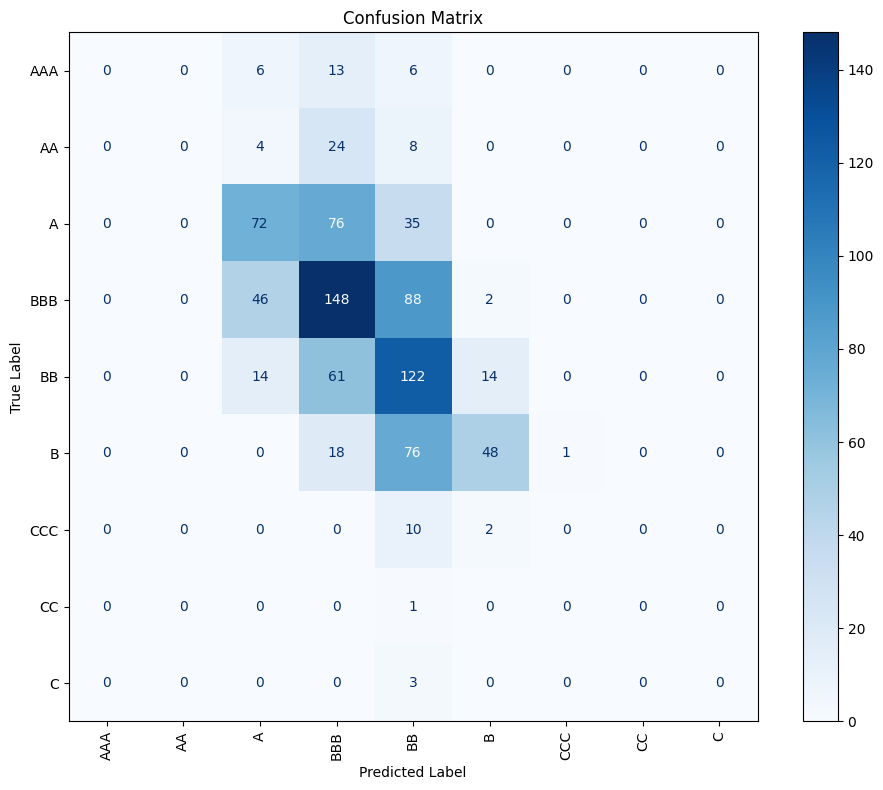

In [9]:
train_and_evaluate_model(df,numeric_feature_columns,cat_feature_columns,target_column,custom_mapping,hyperparameter_settings=best_params_1)

### model 2
we only use tabular financial features

In [10]:
# Extract feature and target column names from the JSON data
cat_feature_columns = []
nlp_feature_columns = []
tabular_feature_columns = column_data['tabular_feature_columns']
target_column = column_data['target_column']

# Construct the features DataFrame
numeric_feature_columns = tabular_feature_columns + nlp_feature_columns

custom_mapping = {'AAA': 0, 'AA': 1, 'A': 2, 'BBB': 3, 'BB': 4, 'B': 5, 'CCC': 6,"CC":7,"C":8,"D":9}


In [11]:
best_model_2, best_params_2 = train_and_evaluate_with_grid_search(df, numeric_feature_columns, cat_feature_columns, target_column, custom_mapping, hyperparameter_settings)

/Users/chengzhengxing/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chengzhengxing/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

Tuned Hyperparameters: {'C': 0.1, 'class_weight': None, 'l1_ratio': 0.0, 'multi_class': 'multinomial', 'penalty': 'elasticnet', 'solver': 'saga'}
Accuracy: 0.46574924486765984
Test Accuracy: 0.5757238307349666


{'accuracy': 0.5757238307349666, 'f1_score': 0.5694424810320398, 'majority_baseline': 0.31625835189309576}
Share of predictions exactly as the actual: 57.57%
Share of predictions 1 or fewer ratings away from actual: 89.64%
Classification Report:
               precision    recall  f1-score   support

         AAA       0.76      0.64      0.70        25
          AA       0.71      0.42      0.53        36
           A       0.61      0.41      0.49       183
         BBB       0.63      0.67      0.65       284
          BB       0.46      0.74      0.57       211
           B       0.69      0.43      0.53       143
         CCC       0.67      0.33      0.44        12
          CC       0.00      0.00      0.00         1
           C       0.00      0.00      0.00         3

    accuracy                           0.58       898
   macro avg       0.50      0.40      0.43       898
weighted avg       0.60      0.58      0.57       898



/Users/chengzhengxing/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chengzhengxing/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chengzhengxing/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

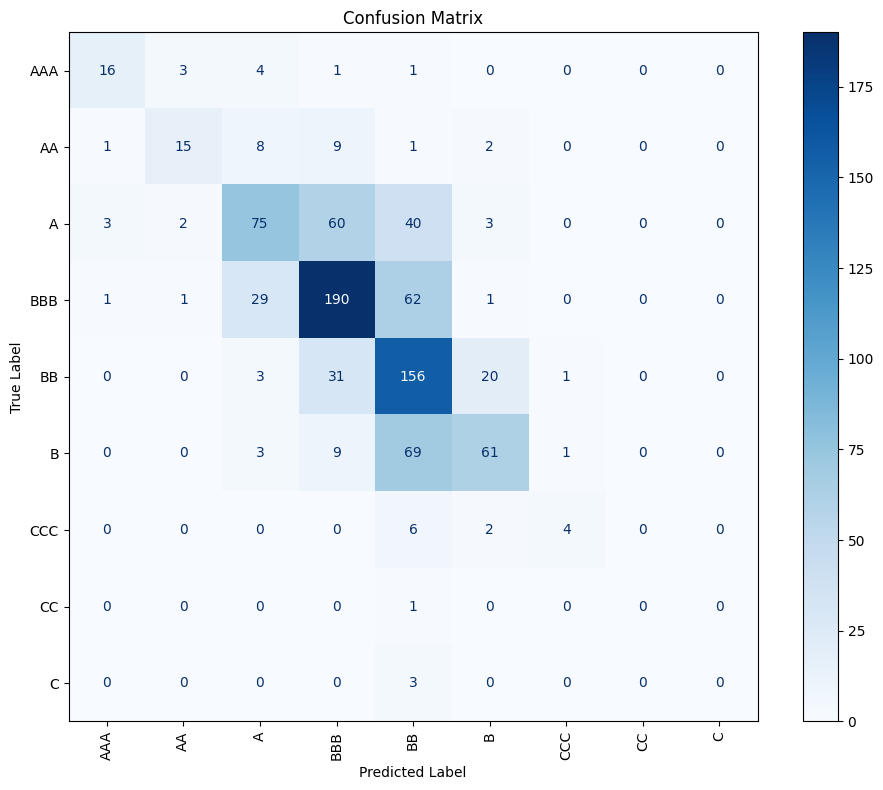

In [12]:
train_and_evaluate_model(df,numeric_feature_columns,cat_feature_columns,target_column,custom_mapping,hyperparameter_settings=best_params_2)

### model 3
We add the categorical features (cat+fin_tabular)

In [13]:
# Extract feature and target column names from the JSON data
cat_feature_columns = column_data['cat_feature_columns']
nlp_feature_columns = []
tabular_feature_columns = column_data['tabular_feature_columns']
target_column = column_data['target_column']

# Construct the features DataFrame
numeric_feature_columns = tabular_feature_columns + nlp_feature_columns

custom_mapping = {'AAA': 0, 'AA': 1, 'A': 2, 'BBB': 3, 'BB': 4, 'B': 5, 'CCC': 6,"CC":7,"C":8,"D":9}

In [14]:
best_model_3, best_params_3 = train_and_evaluate_with_grid_search(df, numeric_feature_columns, cat_feature_columns, target_column, custom_mapping, hyperparameter_settings)

/Users/chengzhengxing/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chengzhengxing/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

Tuned Hyperparameters: {'C': 0.1, 'class_weight': None, 'l1_ratio': 1.0, 'multi_class': 'ovr', 'penalty': 'elasticnet', 'solver': 'saga'}
Accuracy: 0.7778259014658954
Test Accuracy: 0.7939866369710468


/Users/chengzhengxing/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


{'accuracy': 0.7939866369710468, 'f1_score': 0.7927937385854632, 'majority_baseline': 0.31625835189309576}
Share of predictions exactly as the actual: 79.40%
Share of predictions 1 or fewer ratings away from actual: 98.22%
Classification Report:
               precision    recall  f1-score   support

         AAA       0.83      0.76      0.79        25
          AA       0.57      0.47      0.52        36
           A       0.73      0.75      0.74       183
         BBB       0.84      0.81      0.83       284
          BB       0.81      0.84      0.82       211
           B       0.82      0.83      0.82       143
         CCC       0.67      1.00      0.80        12
          CC       0.00      0.00      0.00         1
           C       1.00      1.00      1.00         3

    accuracy                           0.79       898
   macro avg       0.70      0.72      0.70       898
weighted avg       0.79      0.79      0.79       898



/Users/chengzhengxing/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chengzhengxing/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chengzhengxing/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

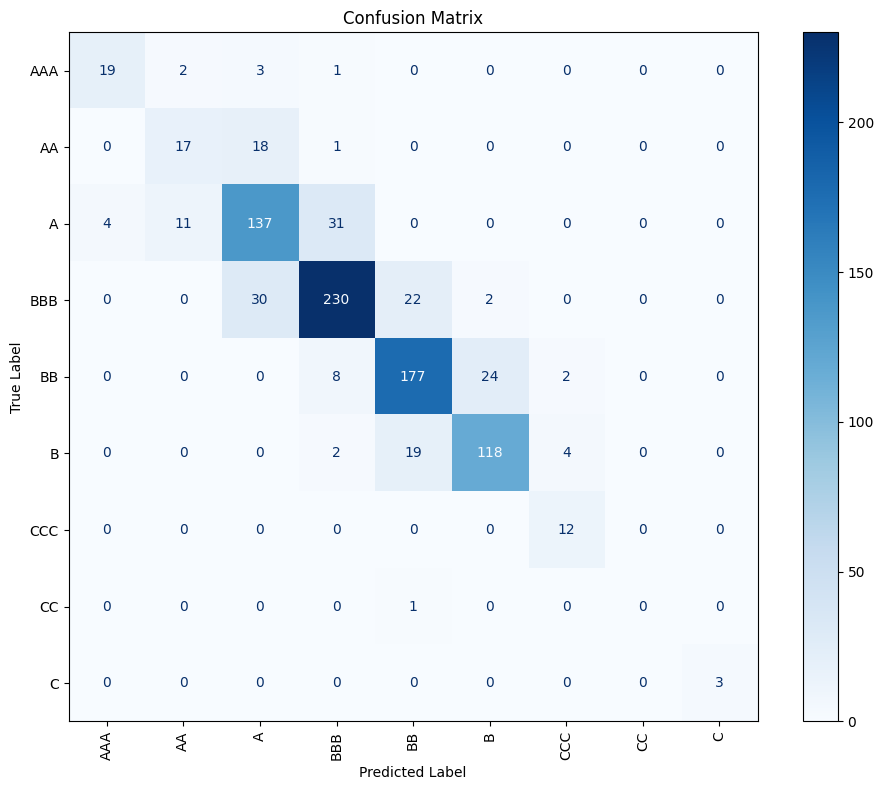

In [15]:
train_and_evaluate_model(df,numeric_feature_columns,cat_feature_columns,target_column,custom_mapping,hyperparameter_settings=best_params_3)

### model 4
We add the nlp features (nlp+cat+fin_tabular)

{'accuracy': 0.8042328042328042, 'f1_score': 0.803487151869701, 'majority_baseline': 0.3100529100529101}
Share of predictions exactly as the actual: 80.42%
Share of predictions 1 or fewer ratings away from actual: 97.88%
Classification Report:
               precision    recall  f1-score   support

         AAA       0.85      0.74      0.79        23
          AA       0.63      0.47      0.54        40
           A       0.76      0.76      0.76       196
         BBB       0.80      0.85      0.83       293
          BB       0.90      0.82      0.86       255
           B       0.78      0.87      0.83       111
         CCC       0.54      0.88      0.67        16
          CC       0.00      0.00      0.00         3
           C       1.00      0.86      0.92         7
           D       1.00      1.00      1.00         1

    accuracy                           0.80       945
   macro avg       0.73      0.72      0.72       945
weighted avg       0.81      0.80      0.80       9

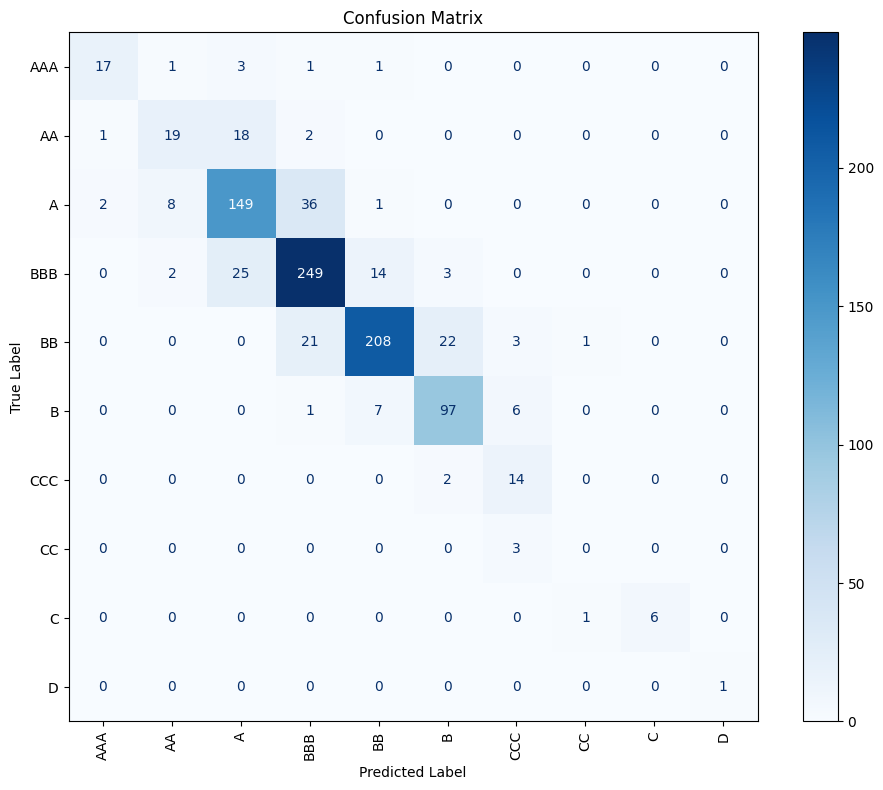

In [16]:
# Extract feature and target column names from the JSON data
cat_feature_columns = column_data['cat_feature_columns']
nlp_feature_columns = column_data['nlp_feature_columns']
tabular_feature_columns = column_data['tabular_feature_columns']
target_column = column_data['target_column']

# Construct the features DataFrame
numeric_feature_columns = tabular_feature_columns + nlp_feature_columns

custom_mapping = {'AAA': 0, 'AA': 1, 'A': 2, 'BBB': 3, 'BB': 4, 'B': 5, 'CCC': 6,"CC":7,"C":8,"D":9}
train_and_evaluate_model(df,numeric_feature_columns,cat_feature_columns,target_column,custom_mapping,test_size=0.2, random_state=2,solver = "lbfgs", penalty='l2')

In [17]:
best_model_4, best_params_4 = train_and_evaluate_with_grid_search(df, numeric_feature_columns, cat_feature_columns, target_column, custom_mapping, hyperparameter_settings)

/Users/chengzhengxing/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chengzhengxing/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

Tuned Hyperparameters: {'C': 0.1, 'class_weight': 'balanced', 'l1_ratio': 1.0, 'multi_class': 'ovr', 'penalty': 'elasticnet', 'solver': 'saga'}
Accuracy: 0.7809614498540931
Test Accuracy: 0.7984409799554566


{'accuracy': 0.7984409799554566, 'f1_score': 0.7985360026274815, 'majority_baseline': 0.31625835189309576}
Share of predictions exactly as the actual: 79.84%
Share of predictions 1 or fewer ratings away from actual: 98.22%
Classification Report:
               precision    recall  f1-score   support

         AAA       0.81      0.88      0.85        25
          AA       0.59      0.61      0.60        36
           A       0.75      0.73      0.74       183
         BBB       0.85      0.81      0.83       284
          BB       0.81      0.83      0.82       211
           B       0.82      0.83      0.82       143
         CCC       0.67      1.00      0.80        12
          CC       0.50      1.00      0.67         1
           C       1.00      1.00      1.00         3

    accuracy                           0.80       898
   macro avg       0.76      0.85      0.79       898
weighted avg       0.80      0.80      0.80       898



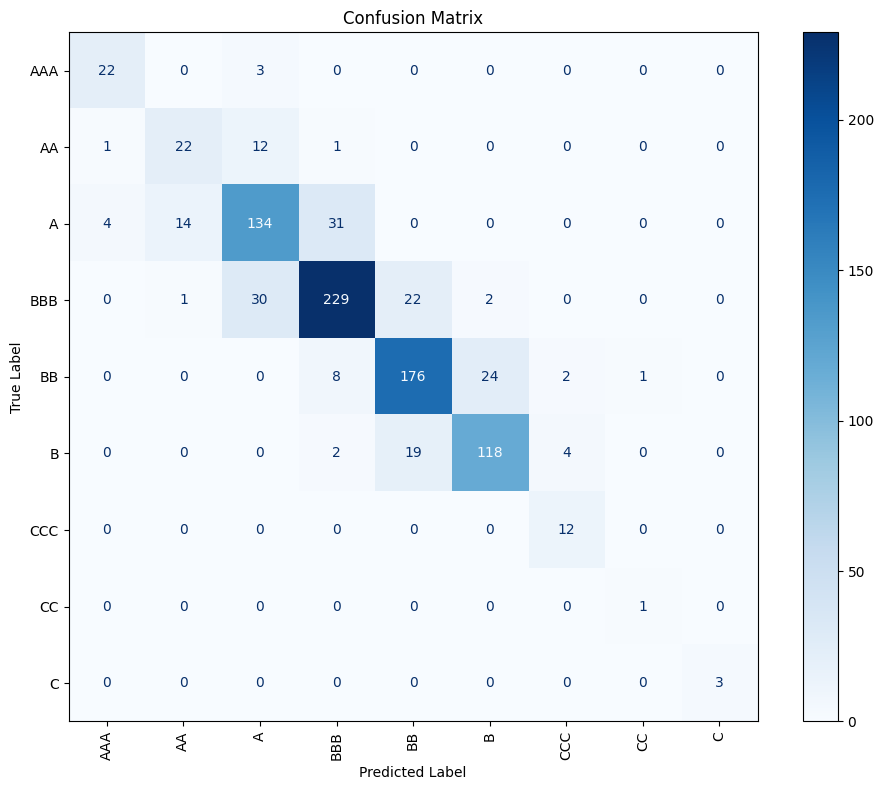

In [18]:
train_and_evaluate_model(df,numeric_feature_columns,cat_feature_columns,target_column,custom_mapping,hyperparameter_settings=best_params_4)

## Task2: Credit Rating Changing Prediction 

# model 1
We add all variables

In [19]:
# Extract feature and target column names from the JSON data
cat_feature_columns = column_data['cat_feature_columns']
nlp_feature_columns = column_data['nlp_feature_columns']
tabular_feature_columns = column_data['tabular_feature_columns']
target_column = 'Change Since Last Fixed Quarter Date'

# Construct the features DataFrame
numeric_feature_columns = tabular_feature_columns + nlp_feature_columns

custom_mapping = {'downgrade': 0, 'no change': 1, 'upgrade': 2}

In [20]:
best_model_5, best_params_5 = train_and_evaluate_with_grid_search(df, numeric_feature_columns, cat_feature_columns, target_column, custom_mapping, hyperparameter_settings,change=True)

/Users/chengzhengxing/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/chengzhengxing/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/chengzhengxing/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/chengzhengxing/opt/anaconda

Tuned Hyperparameters: {'C': 0.001, 'class_weight': None, 'l1_ratio': 0.0, 'multi_class': 'ovr', 'penalty': 'elasticnet', 'solver': 'saga'}
Accuracy: 0.9372716257956621
Test Accuracy: 0.9298440979955457


{'accuracy': 0.9298440979955457, 'f1_score': 0.8960413408266367, 'majority_baseline': 0.9298440979955457}
Share of predictions exactly as the actual: 92.98%
Share of predictions 1 or fewer ratings away from actual: 100.00%
Classification Report:
               precision    recall  f1-score   support

   downgrade       0.00      0.00      0.00        25
   no change       0.93      1.00      0.96       835
     upgrade       0.00      0.00      0.00        38

    accuracy                           0.93       898
   macro avg       0.31      0.33      0.32       898
weighted avg       0.86      0.93      0.90       898



/Users/chengzhengxing/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chengzhengxing/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chengzhengxing/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

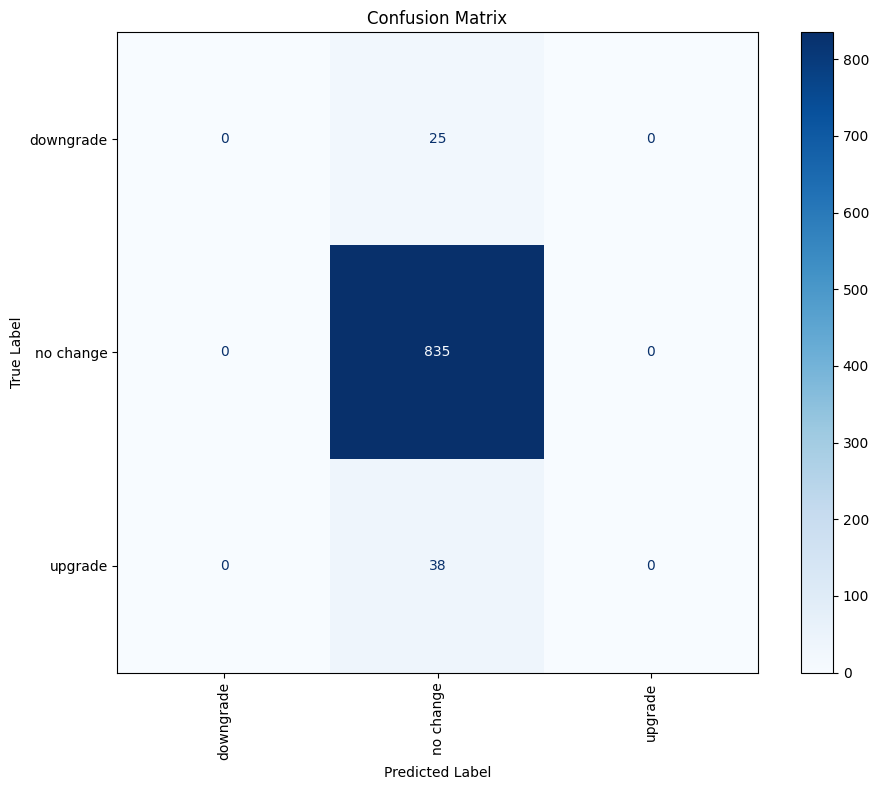

In [21]:
train_and_evaluate_model(df,numeric_feature_columns,cat_feature_columns,target_column,custom_mapping,hyperparameter_settings=best_params_5,change=True)